In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.1"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
import jax.numpy as jnp
import jax
import equinox as eqx

from corrector_src.model._cnn_mhd_corrector import CorrectorCNN
from corrector_src.model._cnn_mhd_corrector_options import (
    CNNMHDParams,
    CNNMHDconfig,
)
from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from omegaconf import OmegaConf
from corrector_src.data.load_sim import (
    load_states,
    integrate_blast,
    filepath_state,
    prepare_initial_state,
)


In [3]:
with initialize(version_base=None, config_path="../../configs"):
    cfg = compose(config_name="config")
    print(cfg)


{'experiment': {'name': 'experiment_1'}, 'data': {'debug': '${training.debug}', 'hr_res': 64, 'downscaling_factor': 2, 'randomizer_1': [0.5, 1.5], 'randomizer_2': [0.5, 1.5], 'randomizer_3': [0.5, 1.5], 'num_snapshots': 80, 'num_checkpoints': 10, 'num_timesteps': 1000, 'generate_data_on_fly': False, 'precomputed_data': True, 'fixed_timestep': False, 'dt_max': 0.1, 't_end': 0.34, 'snapshot_timepoints': [0.2, 0.34], 'use_specific_snapshot_timepoints': True, 'return_snapshots': True}, 'training': {'epochs': 300, 'n_look_behind': 10, 'learning_rate': 0.001, 'return_full_sim': False, 'return_full_sim_epoch_interval': 10, 'rng_key': 60, 'debug': False}, 'models': {'_target_': 'corrector_src.model._cnn_mhd_corrector.CorrectorCNN', 'in_channels': 8, 'hidden_channels': 16}}


# LOAD MODEL

In [4]:
# Create a test model
key = jax.random.PRNGKey(42)
model = CorrectorCNN(in_channels=8, hidden_channels=16, key=key)
model = eqx.tree_deserialise_leaves(
    "/export/home/jalegria/Thesis/jf1uids/experiments/experiment_1/2025-10-08_11-30-03_10/cnn_model.eqx",
    model,
)
# Test input
test_input = jnp.ones((8, 32, 32, 32))

# Test forward pass
output = model(test_input)
print(f"Output shape: {output.shape}")
print(f"Output norm: {jnp.linalg.norm(output)}")
del output, test_input

Output shape: (8, 32, 32, 32)
Output norm: 780.7915380950759


In [5]:
neural_net_params, neural_net_static = eqx.partition(model, eqx.is_array)
cnn_mhd_corrector_config = CNNMHDconfig(
    cnn_mhd_corrector=True, network_static=neural_net_static
)
cnn_mhd_corrector_params = CNNMHDParams(network_params=neural_net_params)

In [6]:
cfg_data = cfg.data
cfg_data.use_specific_snapshot_timepoints = False

lr_initial_state, lr_config, lr_params, lr_helper_data, lr_registered_variables = (
    prepare_initial_state(
        cfg_data=cfg_data,
        rng_seed=30,
        cnn_mhd_corrector_config=cnn_mhd_corrector_config,
        cnn_mhd_corrector_params=cnn_mhd_corrector_params,
        downscale=True,
    )
)

hr_initial_state, hr_config, hr_params, hr_helper_data, hr_registered_variables = (
    prepare_initial_state(
        cfg_data=cfg_data,
        rng_seed=30,
        cnn_mhd_corrector_config=None,
        cnn_mhd_corrector_params=None,
        downscale=False,
    )
)
print(jnp.shape(lr_initial_state), jnp.shape(hr_initial_state))

use_specific_snapshot_times was False or snapshot times were not given
use_specific_snapshot_times was False or snapshot times were not given
(8, 32, 32, 32) (8, 64, 64, 64)


In [15]:
import matplotlib.pyplot as plt

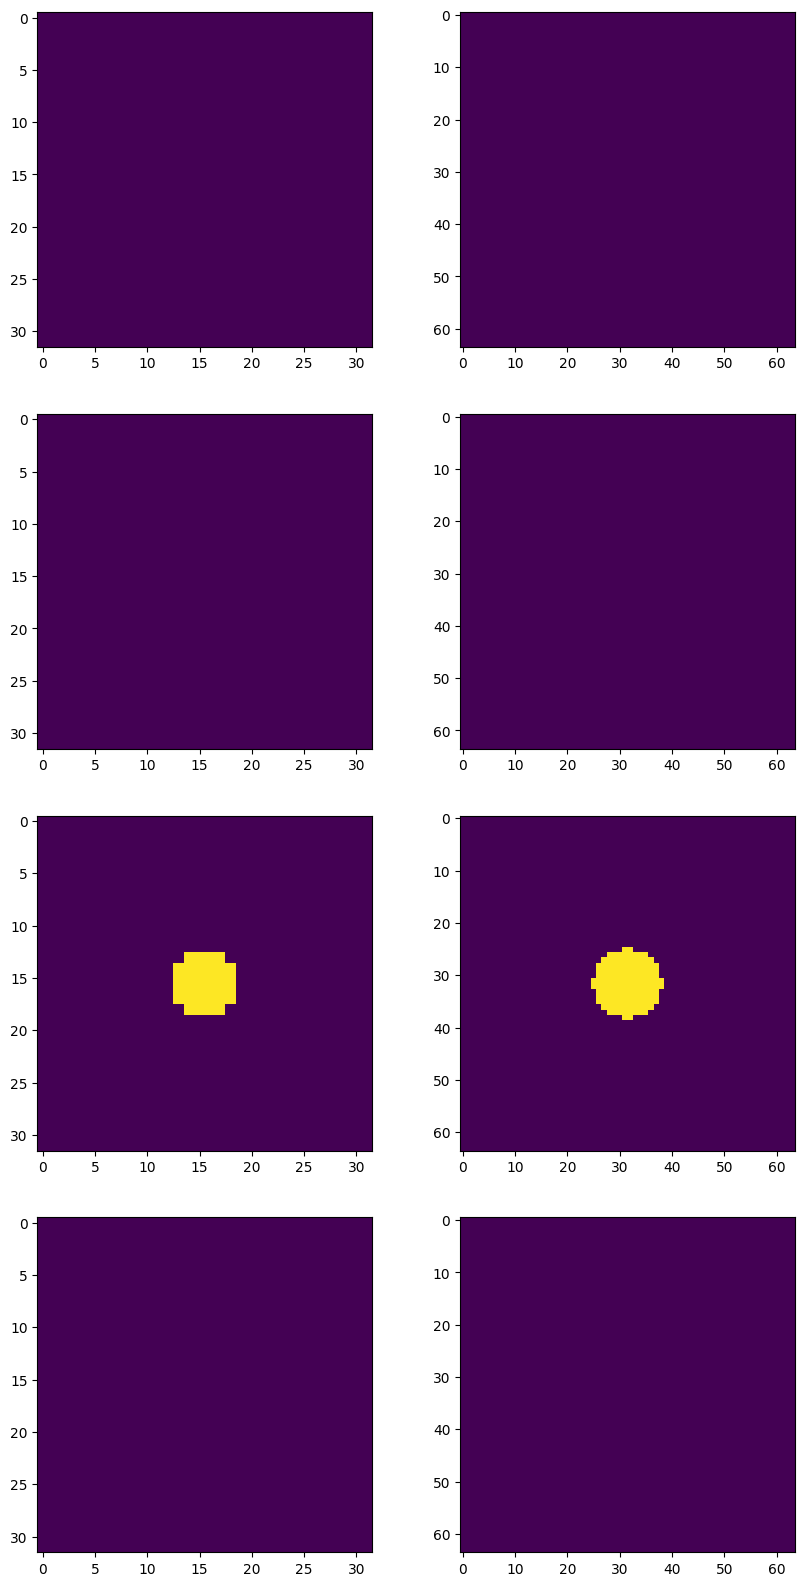

In [19]:
fig, ax = plt.subplots(4, 2, figsize = (10, 20))
#density 0
#velocity 1,2,3
#pressure 4
#magnetic field 5, 6,7
ax[0][0].imshow(lr_initial_state[0, :, :, 16])
ax[0][1].imshow(hr_initial_state[0, :, :, 32])

ax[1][0].imshow(jnp.sqrt(lr_initial_state[1, :, :, 16]**2+ lr_initial_state[2, :, :, 16]**2+ lr_initial_state[3, :, :, 16]**2))
ax[1][1].imshow(
    jnp.sqrt(
        hr_initial_state[1, :, :, 32] ** 2
        + hr_initial_state[2, :, :, 32] ** 2
        + hr_initial_state[3, :, :, 32] ** 2
    )
)

ax[2][0].imshow(lr_initial_state[4, :, :, 16])
ax[2][1].imshow(hr_initial_state[4, :, :, 32])

ax[3][0].imshow(
    jnp.sqrt(
        lr_initial_state[5, :, :, 16] ** 2
        + lr_initial_state[6, :, :, 16] ** 2
        + lr_initial_state[7, :, :, 16] ** 2
    )
)
ax[3][1].imshow(
    jnp.sqrt(
        hr_initial_state[5, :, :, 32] ** 2
        + hr_initial_state[6, :, :, 32] ** 2
        + hr_initial_state[7, :, :, 32] ** 2
    )
)

In [ ]:
from jf1uids import time_integration

final_state = time_integration(
    lr_initial_state, lr_config, lr_params, lr_helper_data, lr_registered_variables
)

